In [1]:
from model import NeRF
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from dataloader import OneDCurveData

In [2]:
from vis import *
from run_nerf import *

In [3]:
import torch

In [ ]:
# train
model = NeRF()
trainer = pl.Trainer(gpus=1)
dataset = OneDCurveData()
train_loader = DataLoader(dataset, batch_size=64)
# trainer.fit(model, train_loader)

In [ ]:
# eval
model = NeRF.load_from_checkpoint('lightning_logs/version_34_10/checkpoints/epoch=401-step=401.ckpt')
model.eval()
model.cuda()
with torch.no_grad():
    x, y, res = render_path_circle(model)
res = res.cpu()

In [ ]:
# take one step and output intermediate results


In [74]:
ckpt_dict = {28: "/mnt/volume2/Data/zlz/shzhou2/project/nerf/lightning_logs/version_28_good/checkpoints/epoch=8-step=1412.ckpt",
            34: "lightning_logs/version_34_10/checkpoints/epoch=401-step=401.ckpt",
            32: "/mnt/volume2/Data/zlz/shzhou2/project/nerf/lightning_logs/version_32_100/checkpoints/epoch=231-step=463.ckpt",
            33: "/mnt/volume2/Data/zlz/shzhou2/project/nerf/lightning_logs/version_33_50/checkpoints/epoch=326-step=326.ckpt",
            48: "/mnt/volume2/Data/zlz/shzhou2/project/nerf/lightning_logs/version_48/checkpoints/epoch=149-step=149.ckpt"
            }

# Weights on a ray: (eval)
1. What is the weight & color prediction along one ray? Ideally, it should be symmetric: if one ray shoots from two opposite directions, then the color should be the same, and the weights should be just the opposite. 
2. Because of occlusion, the weigth should be placed on the contact point (and no where else ideally)



In [75]:
import math
cuda = True
model = NeRF.load_from_checkpoint(ckpt_dict[48])
model.eval()
model.cuda()


NeRF(
  (layer1): Linear(in_features=2, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3_1): Linear(in_features=128, out_features=1, bias=True)
  (layer3_2): Linear(in_features=128, out_features=128, bias=True)
  (layer4): Linear(in_features=129, out_features=128, bias=True)
  (layer5): Linear(in_features=128, out_features=128, bias=True)
  (layer6): Linear(in_features=128, out_features=3, bias=True)
)

In [76]:
with torch.no_grad():
    r = 3
    theta = torch.tensor([0, math.pi]) # torch.linspace(0, 2 * math.pi, 360)
    x, y = r * torch.cos(theta), r * torch.sin(theta)
    rays_o = torch.stack([x, y]).t()
    rays_d = -theta
    view_dirs = rays_d
    if cuda:
        rays_o, rays_d, view_dirs = rays_o.cuda(), rays_d.cuda(), view_dirs.cuda()
    raw, z_vals = render_rays_step(rays_o, rays_d, view_dirs, model.forward)
    y_hat, weight, rgb = raw2outputs_step(raw, z_vals)

In [8]:
import matplotlib.pyplot as plt

<BarContainer object of 64 artists>

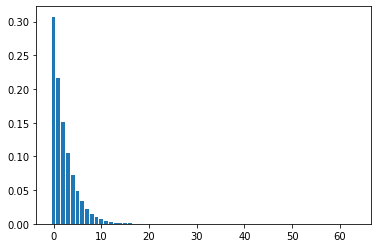

In [10]:
plt.bar(np.arange(weight.shape[1]), weight[0].cpu())

<BarContainer object of 64 artists>

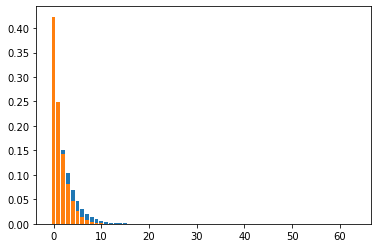

In [80]:
plt.bar(np.arange(weight.shape[1]), weight[0].cpu())
plt.bar(np.arange(weight.shape[1]), weight[1].cpu())

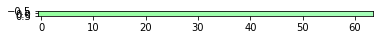

In [78]:
plt.imshow(rgb[0:1].cpu())

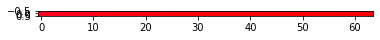

In [79]:
plt.imshow(rgb[1:2].cpu())

# Weight updating: (train)
Using small number of points (20 maybe), how the weight & color on them changes? 

In [34]:
def raw2outputs_step(raw, z_vals):
    dists = z_vals[...,1:] - z_vals[...,:-1]
    if cuda:
        dists = torch.cat([dists, torch.Tensor([1e10]).expand(dists[...,:1].shape).cuda()], -1)
    else:
        dists = torch.cat([dists, torch.Tensor([1e10]).expand(dists[...,:1].shape)], -1)
    
    rgb = torch.sigmoid(raw[...,:3])
    alpha = sigma2alpha(raw[...,3], dists)
    
    # import pdb; pdb.set_trace()
    if cuda:
        weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1)).cuda(), 1.-alpha + 1e-10], -1), -1)[..., :-1]
    else:
        weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1)), 1.-alpha + 1e-10], -1), -1)[..., :-1]
    # import pdb; pdb.set_trace()
    rgb_map = torch.sum(weights[...,None] * rgb, -2)
    return rgb_map, weights, rgb   

def render_rays_step(rays_o, rays_d, view_dirs, network_fn):
    near = 0
    far = 4
    n_samples = 64
    if cuda:
        z_vals = linear_sample(near, far, n_samples).cuda()
    else:
        z_vals = linear_sample(near, far, n_samples)
    # import pdb; pdb.set_trace()

    pts = rays_o[...,None,:] + torch.stack([torch.cos(rays_d)[...,None] * z_vals[None, ...], torch.sin(rays_d)[...,None] * z_vals[None, ...]], -1)
    raw = network_fn(torch.cat([pts, view_dirs[...,None, None].expand((-1, n_samples, 1))],-1))
    return raw, z_vals

In [55]:
import torch.nn as nn
import torch
import pytorch_lightning as pl
import torch.nn.functional as F
class NeRF_Debug(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.relu = nn.functional.relu
        self.xyz_encoding_dims = 2
        self.viewdir_encoding_dims = 1
        self.hidden_size = hidden_size = 128
        self.layer1 = nn.Linear(self.xyz_encoding_dims, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3_1 = nn.Linear(hidden_size, 1)
        self.layer3_2 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(
            self.viewdir_encoding_dims + hidden_size, hidden_size
        )
        self.layer5 = nn.Linear(hidden_size, hidden_size)
        self.layer6 = nn.Linear(hidden_size, 3)

    def forward(self, x):
        x, view = x[..., :-1], x[..., -1:]
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        sigma = self.layer3_1(x)
        feat = self.relu(self.layer3_2(x))
        x = torch.cat((feat, view), dim=-1)
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        c = self.layer6(x)
        raw = torch.cat((c, sigma), dim=-1)
        return raw

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        y = y.float()
        # import pdb; pdb.set_trace()
        rays_d = x[:, 2]
        rays_o = x[:, :2]
        view_dirs = rays_d
        raw, z_vals = render_rays_step(rays_o, rays_d, view_dirs, self.forward)
        # import pdb; pdb.set_trace()
        y_hat, weight, rgb = raw2outputs_step(raw, z_vals)
        step_size = 1000
        if self.global_step % step_size == 0:
            torch.save(weight, 'weight_{}.pth'.format(self.global_step // step_size))
            torch.save(rgb, 'rgb_{}.pth'.format(self.global_step // step_size))
        # import pdb; pdb.set_trace()
        loss = F.mse_loss(y_hat, y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, betas=(0.9, 0.999))
        return optimizer


In [57]:
import time
model = NeRF_Debug()
trainer = pl.Trainer(gpus=1, max_steps=150)
dataset = OneDCurveData()
train_loader = DataLoader(dataset, batch_size=64)
trainer.fit(model, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name     | Type   | Params
------------------------------------
0 | layer1   | Linear | 384   
1 | layer2   | Linear | 16.5 K
2 | layer3_1 | Linear | 129   
3 | layer3_2 | Linear | 16.5 K
4 | layer4   | Linear | 16.6 K
5 | layer5   | Linear | 16.5 K
6 | layer6   | Linear | 387   
------------------------------------
67.1 K    Trainable params
0         Non-trainable params
67.1 K    Total params
0.268     Total estimated model params size (MB)


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s, loss=5.48e-05, v_num=48]


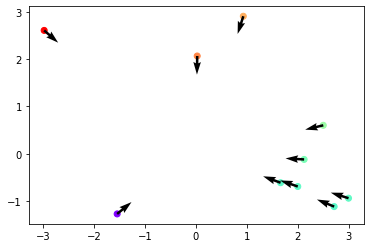

In [62]:
x, y, theta, c = dataset.x, dataset.y, dataset.view, dataset.color

vis_data(x, y, theta, c)

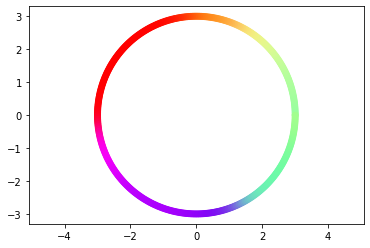

In [63]:
model = NeRF.load_from_checkpoint('lightning_logs/version_48/checkpoints/epoch=149-step=149.ckpt')
model.eval()
model.cuda()
with torch.no_grad():
    x, y, res = render_path_circle(model)
res = res.cpu()
# import pdb; pdb.set_trace()
vis_res(x, y, res)

In [ ]:
model = NeRF.load_from_checkpoint('lightning_logs/version_51_good/checkpoints/epoch=169-step=7989.ckpt')
model.eval()
model.cuda()
with torch.no_grad():
    x, y, res = render_path_circle(model)
res = res.cpu()
# import pdb; pdb.set_trace()
vis_res(x, y, res)

In [5]:
rgb.shape

torch.Size([64, 64, 3])

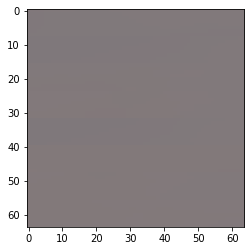

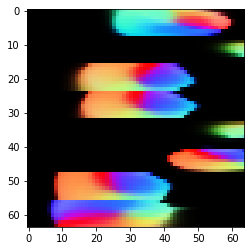

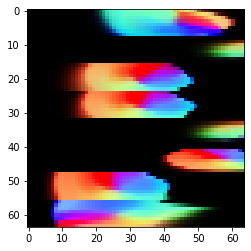

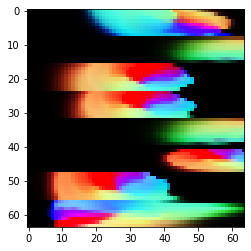

In [8]:
import torch
import matplotlib.pyplot as plt
with torch.no_grad():
    for i in range(4):
        rgb = torch.load('rgb_{}.pth'.format(i), map_location='cpu')
        weight = torch.load('weight_{}.pth'.format(i), map_location='cpu')
        plt.imshow(rgb)
        plt.show()

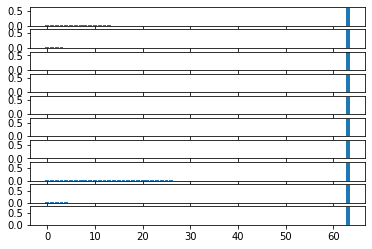

done


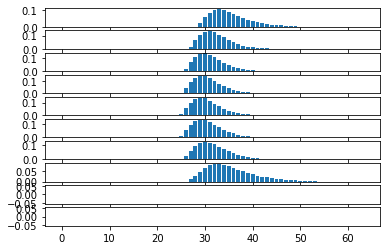

done


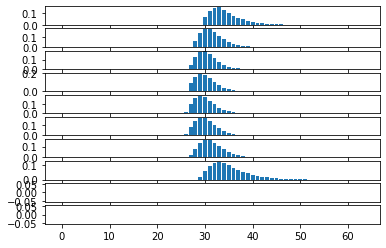

done


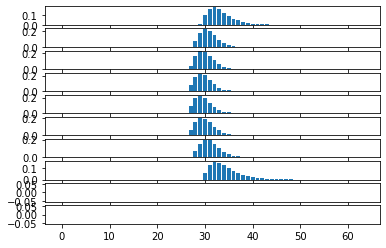

done


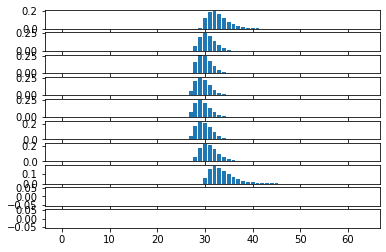

done


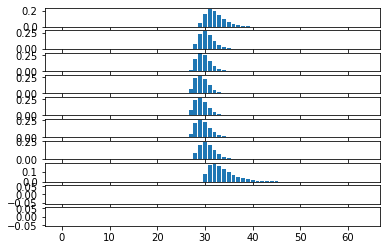

done


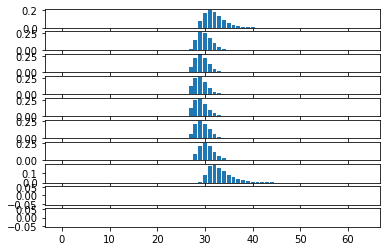

done


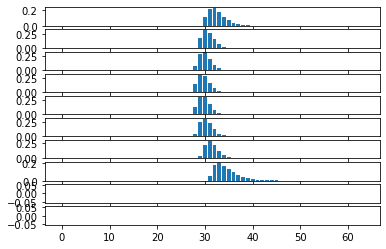

done


FileNotFoundError: [Errno 2] No such file or directory: 'weight_8.pth'

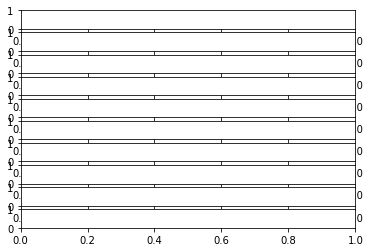

In [9]:
import numpy as np
import matplotlib.pyplot as plt
 
with torch.no_grad():
    for i in range(7):
        fig, axs = plt.subplots(10)
        # rgb = torch.load('rgb_{}.pth'.format(i))
        weight = torch.load('weight_{}.pth'.format(i), map_location='cpu')
        for j in range(10):
            axs[j].bar(np.arange(weight.shape[1]), weight[j].cpu())
        plt.show()
        print('done')
        # plt.imshow(rgb.cpu())

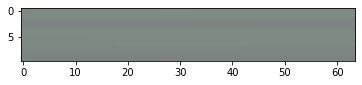

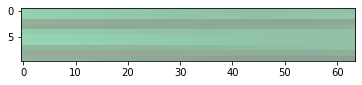

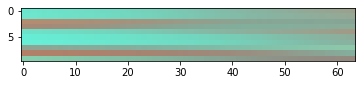

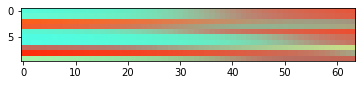

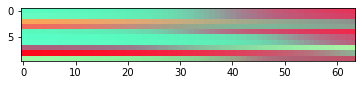

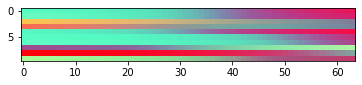

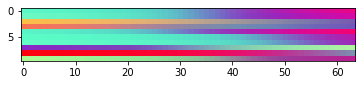

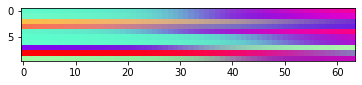

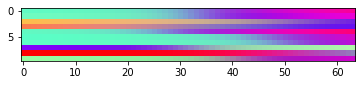

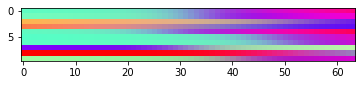

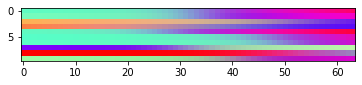

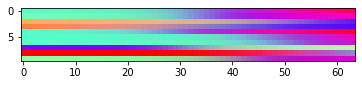

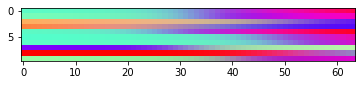

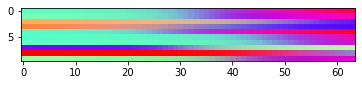

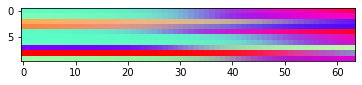

In [58]:
with torch.no_grad():
    for i in range(15):
        rgb = torch.load('rgb_{}.pth'.format(i))
        weight = torch.load('weight_{}.pth'.format(i))
        plt.imshow(rgb.cpu())
        plt.show()
        # print(weight.shape)
        

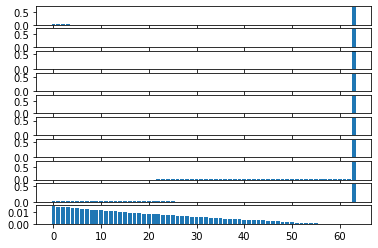

done


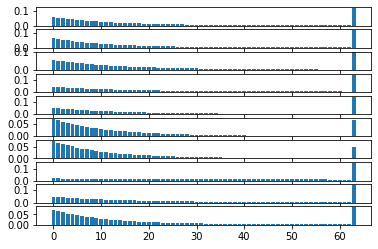

done


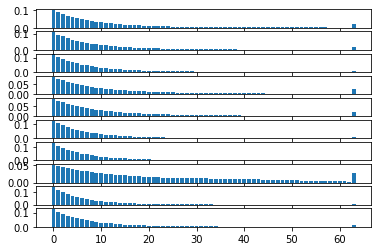

done


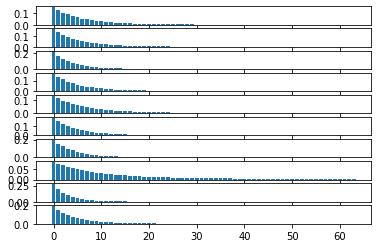

done


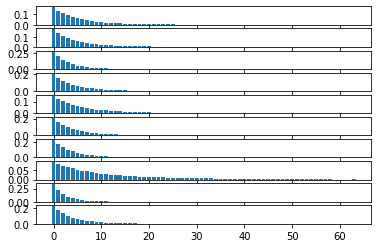

done


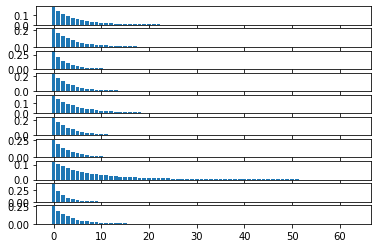

done


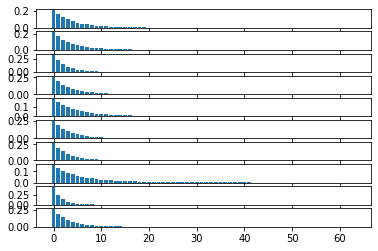

done


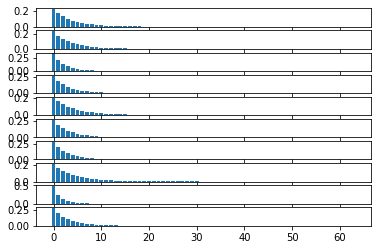

done


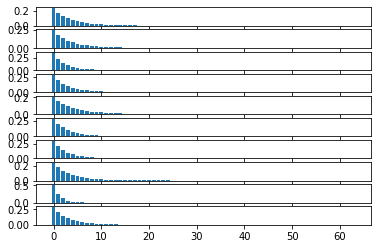

done


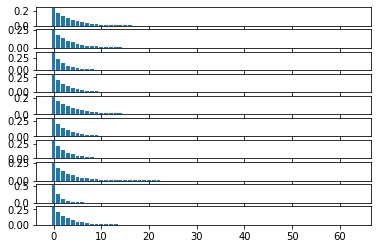

done


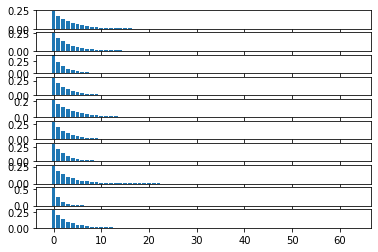

done


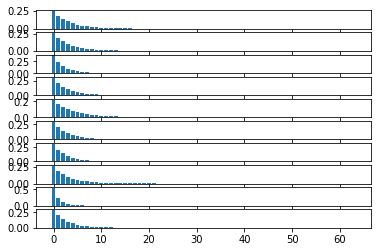

done


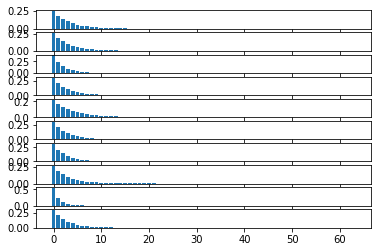

done


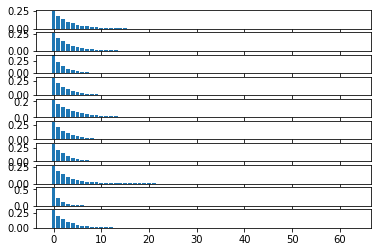

done


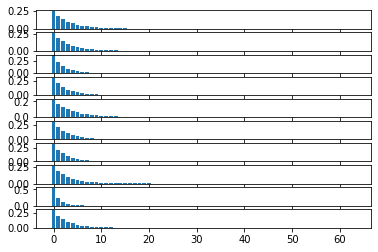

done


In [68]:
with torch.no_grad():
    
    for i in range(15):
        fig, axs = plt.subplots(10)
        # rgb = torch.load('rgb_{}.pth'.format(i))
        weight = torch.load('weight_{}.pth'.format(i)).cpu()
        for j in range(10):
            axs[j].bar(np.arange(weight.shape[1]), weight[j].cpu())
        plt.show()
        print('done')
        # plt.imshow(rgb.cpu())
        

(-2.2, 2.2, -1.0999894440174103, 1.0999894440174103)

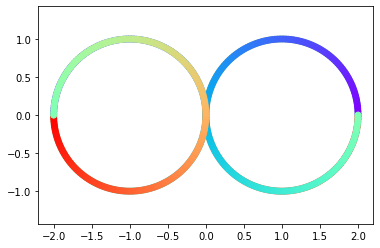

In [83]:
from dataloader import curve_color
r = 1
theta = torch.linspace(0, 2 * math.pi, 360)
x = r * torch.cos(theta)
y = r * torch.sin(theta)

# x, y = x.numpy(), y.numpy()
c1 = curve_color(x/r, y/r)
c2 = curve_color(x/r, -y/r)

x1, y1 = 1 + torch.cos(2 * theta), torch.sin(2 * theta)
x2, y2 = -x1, -y1
plt.scatter(x1, y1, c=c1)
plt.scatter(x2, y2, c=c2)
plt.axis('equal')
# plt.quiver(x, y, np.cos(theta), np.sin(theta))

In [59]:
i = 1
weight = torch.load('weight_{}.pth'.format(i)).cpu()

In [60]:
weight.shape

torch.Size([10, 64])

In [51]:
from run_nerf import render_rays
def render_path_circle(model, cuda=True):
    """
    Sample points along the circle and render what is the view
    """
    r = 4
    theta = torch.linspace(0, 2 * math.pi, 360)
    x, y = r * torch.cos(theta), r * torch.sin(theta)
    rays_o = torch.stack([x, y]).t()
    rays_d = (theta + math.pi + math.pi) % (2 * math.pi) - math.pi
    view_dirs = rays_d
    if cuda:
        rays_o, rays_d, view_dirs = rays_o.cuda(), rays_d.cuda(), view_dirs.cuda()
    res = render_rays(rays_o, rays_d, view_dirs, model.forward)
    return x, y, res

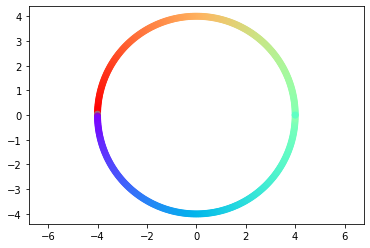

In [56]:
from model import NeRF
import torch
from vis import vis_res
import math
model = NeRF.load_from_checkpoint('lightning_logs/version_94/checkpoints/epoch=380-step=15239.ckpt')
# model = NeRF.load_from_checkpoint('lightning_logs/version_77/checkpoints/epoch=215-step=30455.ckpt')
model.eval()
model.cuda()
with torch.no_grad():
    x, y, res = render_path_circle(model)
res = res.cpu().clip(0, 1)
# import pdb; pdb.set_trace()
vis_res(x, y, res)

## show the weight for points at different distances. Is the network able to get the sense where the contact will happen
Maybe also retrain the network for different radius, is the network still able to learn the mapping?

In [204]:
from model import NeRF
import torch
from vis import vis_res
import math
model = NeRF.load_from_checkpoint('lightning_logs/version_94/checkpoints/epoch=380-step=15239.ckpt')
# model = NeRF.load_from_checkpoint('lightning_logs/version_77/checkpoints/epoch=215-step=30455.ckpt')
model.eval()
model.cuda()

NeRF(
  (layer1): Linear(in_features=2, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3_1): Linear(in_features=128, out_features=1, bias=True)
  (layer3_2): Linear(in_features=128, out_features=128, bias=True)
  (layer4): Linear(in_features=129, out_features=128, bias=True)
  (layer5): Linear(in_features=128, out_features=128, bias=True)
  (layer6): Linear(in_features=128, out_features=3, bias=True)
)

In [205]:
# sample 10 points, record their rays_o, rays_d, and predicted color and weights
r = 4
n_samples = 36
theta = torch.linspace(0, 2 * math.pi, n_samples)
x, y = r * torch.cos(theta), r * torch.sin(theta)
rays_o = torch.stack([x, y]).t()
rays_d = (theta + math.pi + math.pi) % (2 * math.pi) - math.pi
view_dirs = rays_d
rays_o, rays_d, view_dirs = rays_o.cuda(), rays_d.cuda(), view_dirs.cuda()

In [206]:
from run_nerf import *
with torch.no_grad():
    raw, z_vals = render_rays_step(rays_o, rays_d, view_dirs, model.forward)
    y_hat, weight, rgb = raw2outputs_step(raw, z_vals)

In [207]:
pts = rays_o[...,None,:] + torch.stack([torch.cos(rays_d)[...,None] * z_vals[None, ...], torch.sin(rays_d)[...,None] * z_vals[None, ...]], -1)

In [208]:
pts = pts.cpu().detach()

In [209]:
weight.shape

torch.Size([36, 64])

In [210]:
theta = np.linspace(0, math.pi * 2, 360)
x_c, y_c =  np.cos(theta), np.sin(theta)

(-4.383092069625855, 4.399194860458374, -4.395569622516632, 4.395569384098053)

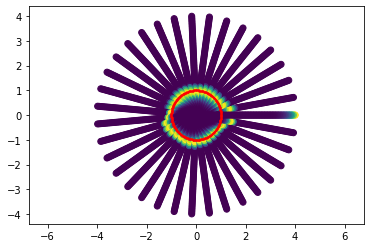

In [211]:
for i in range(n_samples):
    plt.scatter(pts[i, :, 0], pts[i, :, 1], c=weight[i].cpu())
plt.scatter(x_c, y_c, c='r', s=1)
plt.axis('equal')
    

(-1.2499597961744235,
 4.249998085532115,
 -1.0999894703762378,
 1.0999894703762378)

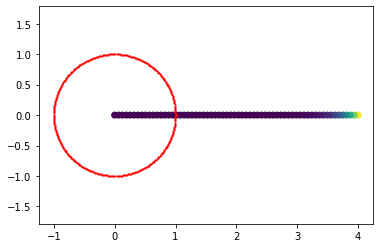

In [214]:
for i in range(n_samples):
    plt.scatter(pts[i, :, 0], pts[i, :, 1], c=weight[i].cpu())
    break
plt.scatter(x_c, y_c, c='r', s=1)
plt.axis('equal')
    

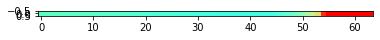

In [215]:
plt.imshow(rgb[0:1].cpu())

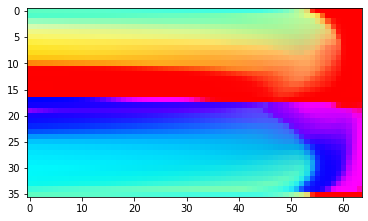

In [217]:
plt.imshow(rgb.cpu())

In [219]:
dataset = torch.load('dataset.pth', map_location='cpu')

In [222]:
t_sample = torch.atan2(dataset.view[:, 1], dataset.view[:, 0])

In [225]:
plt.hist(t_sample.cpu(), bins=50)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f71909aea60> (for post_execute):


KeyboardInterrupt: 

In [224]:
(t_sample < 1).sum()

tensor(13367)

In [110]:
rays_d.shape

torch.Size([12])

In [102]:
rays_o.shape

torch.Size([12, 2])

In [103]:
z_vals.shape

torch.Size([64])

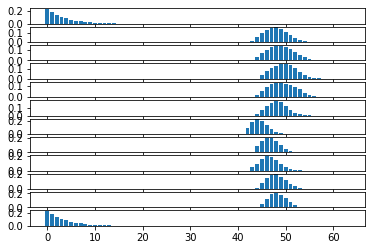

In [74]:
import numpy as np
import matplotlib.pyplot as plt

n_samples = y_hat.shape[0]
fig, ax = plt.subplots(n_samples)
for i in range(n_samples):
    ax[i].bar(np.arange(weight.shape[1]), weight[i].cpu())
plt.show()


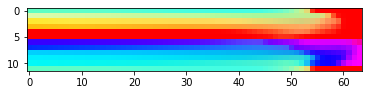

In [75]:
plt.imshow(rgb.cpu())

## show render volume 

Beyond the visible range, the network is still repeating the pattern. It is understandable as there is no data for the network to learn what is beyond the visible angle (for that point, it will see )


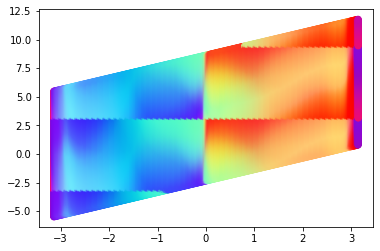

In [193]:
# model = NeRF.load_from_checkpoint('/mnt/volume2/Data/zlz/shzhou2/project/nerf/lightning_logs/version_91/checkpoints/epoch=216-step=34068.ckpt')
# model = NeRF.load_from_checkpoint('lightning_logs/version_94/checkpoints/epoch=380-step=15239.ckpt')
model = NeRF.load_from_checkpoint('lightning_logs/version_57_part/checkpoints/epoch=165-step=2655.ckpt')
model.eval()
model.cuda()
thetas = torch.linspace(-math.pi, math.pi, 360)
colors = []
for theta in thetas:
    theta = theta[None, ...]
    x = torch.cos(theta)
    y = torch.sin(theta)
    # view = torch.linspace(theta[0] + math.pi/2, theta[0] + math.pi/2*3, 180)
    view = torch.linspace(theta[0]-math.pi, theta[0] + math.pi/2*4 + math.pi, 180)
    view = (view + math.pi) % (2 * math.pi) - math.pi
    # color = curve_color(x, y)
    data = torch.stack([x.expand(view.shape[0]), y.expand(view.shape[0]), view]).t()
    res = torch.sigmoid(model.forward(data.cuda())[:, :3])
    colors.append(res)
# thetas = torch.linspace(-math.pi, math.pi, 360)
for i, theta in enumerate(thetas):
    theta = theta[None, ...]
    view = torch.linspace(theta[0]-math.pi, theta[0] + math.pi/2*4 + math.pi, 180)

    # view = torch.linspace(theta[0] + math.pi/2, theta[0]+ math.pi/2*3, 180)
    theta = theta.expand(view.shape[0])
    plt.scatter(theta, view, c=colors[i].cpu().detach())

### Rerun experiment for dx,dy variant

In [226]:
from model import NeRF_New
model = NeRF_New.load_from_checkpoint('lightning_logs/version_107_dx_dy/checkpoints/epoch=394-step=31204.ckpt')
model.eval()
model.cuda()

ImportError: cannot import name 'NeRF_New' from 'model' (/mnt/volume2/Data/zlz/shzhou2/project/nerf/model.py)

# More views & more sampling points 

# Does it matter to keep sampling on each ray, or we can fix that (train)